In [1]:
import os
current_dir = os.getcwd() 
import sys
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', '..', 'src')))
import matplotlib.pyplot as plt

import torch
from gnm import defaults, utils, evaluation, fitting, generative_rules, weight_criteria

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
distance_matrix = defaults.get_distance_matrix(device=DEVICE)
weighted_network = defaults.get_weighted_network(device=DEVICE)

In [19]:
# Get the sparsity of the weighted_network
real_sparsity = (weighted_network == 0).sum() / ( weighted_network.shape[-1]**2 )
print(f"Real sparsity: {real_sparsity}")

Real sparsity: 0.9012345671653748


In [4]:
binary_sweep_parameters = fitting.BinarySweepParameters(
    eta = torch.Tensor([0.0]),
    gamma = torch.Tensor([0.0]),
    lambdah = torch.Tensor([0.0]),
    distance_relationship_type = ["powerlaw"],
    preferential_relationship_type = ["powerlaw"],
    heterochronicity_relationship_type = ["powerlaw"],
    generative_rule = [generative_rules.Geometric()],
    binary_updates_per_iteration = [0],
    num_iterations = [1000],
)

num_simulations = 100

In [5]:
W = defaults.get_weighted_network(device=DEVICE)
normalised_W = W/W.max()
num_simulations = 100
seed_weight_matrix = torch.stack( [ utils.get_control(normalised_W).squeeze(0) for _ in range(num_simulations) ] )
seed_weight_matrix.shape

torch.Size([100, 90, 90])

In [29]:
num_nodes = seed_weight_matrix.shape[-1]
seed_adjacency_matrix = torch.ones( (num_nodes, num_nodes ), device=DEVICE).fill_diagonal_(0)

What would I actually need to do to do this properly? 
1. Regularisation strength
2. Base optimisation criterion -> Communicability, Some other stuff. 
3. Regulariser -> WeightedDistance, SquaredWeightedDistance, 
3. num_iterations

In [ ]:
from gnm.weight_criteria import Communicability, WeightedDistance

regularisation_strengths = [0.0, 0.05, 0.1, 0.2]

optimisation_criteria = [ Communicability() - beta * WeightedDistance(distance_matrix=distance_matrix) for beta in regularisation_strengths ]

weighted_sweep_parameters = fitting.WeightedSweepParameters(
    alpha = [0.01],
    optimisation_criterion = optimisation_criteria,
    maximise_criterion = [True],
)  

sweep_config = fitting.SweepConfig(
    binary_sweep_parameters = binary_sweep_parameters,
    weighted_sweep_parameters = weighted_sweep_parameters,
    seed_adjacency_matrix = [seed_adjacency_matrix],
    seed_weight_matrix = [seed_weight_matrix],
    distance_matrix = [distance_matrix],
)

In [31]:
criteria = [ evaluation.WeightedNodeStrengthKS(normalise=True), evaluation.WeightedClusteringKS() ]
energy = evaluation.MaxCriteria( criteria )
weighted_evaluations = [energy]

In [32]:
experiments = fitting.perform_sweep(sweep_config=sweep_config, 
                                real_weighted_matrices=weighted_network,
                                weighted_evaluations=weighted_evaluations,
                                save_run_history=True,
                                save_model=True,
)

Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:11<00:00, 89.71it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:13<00:00, 71.93it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:11<00:00, 88.58it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:10<00:00, 93.04it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:10<00:00, 94.89it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:10<00:00, 97.50it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:10<00:00, 94.91it/s]


Number of nodes unspecified. Extracting from distance matrix.
Number of nodes set to 90
Number of simulations unspecified. Extracting from seed weight matrix.
Number of simulations set to 100


100%|██████████| 1000/1000 [00:10<00:00, 96.60it/s]


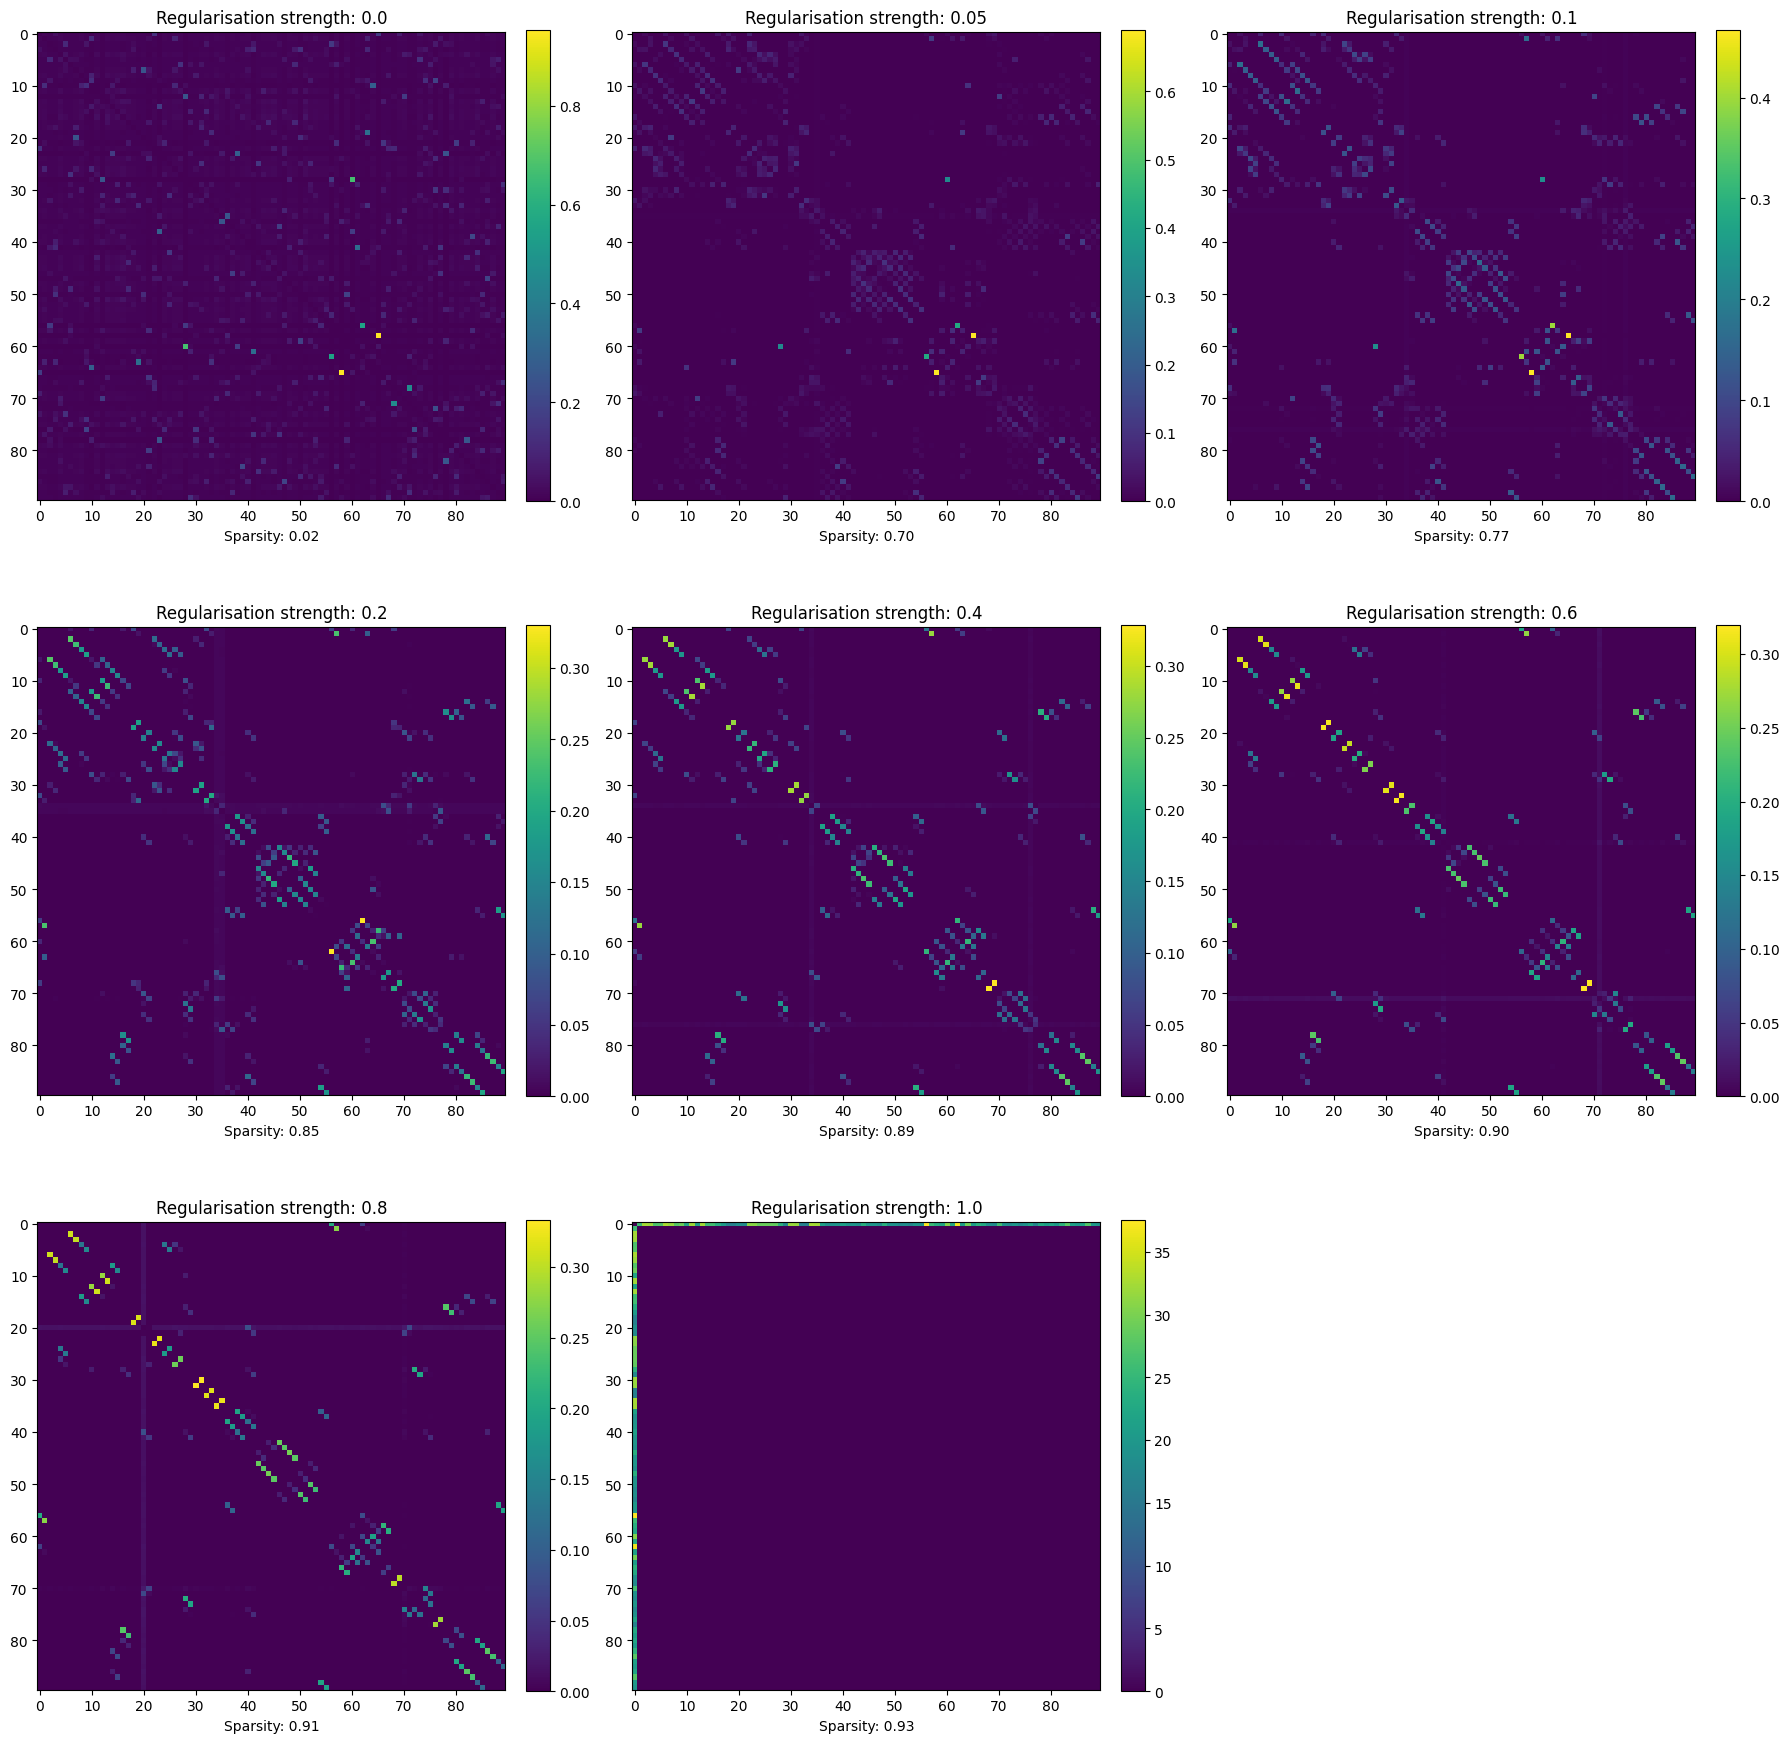

In [33]:
import math

# Calculate grid dimensions to make it as square as possible
n_plots = len(experiments)
n_cols = math.ceil(math.sqrt(n_plots))
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))

# Flatten the axes array to make indexing simpler
axes = axes.flatten() if n_plots > 1 else [axes]

for i, experiment in enumerate(experiments):
    if i < n_plots:  # Make sure we don't exceed the number of experiments
        matrix = experiment.model.weight_matrix.detach().numpy()
        im = axes[i].imshow(matrix[0], cmap='viridis')
        
        # Set title based on regularisation strength if available
        if i < len(regularisation_strengths):
            axes[i].set_title(f"Regularisation strength: {regularisation_strengths[i]}")
        else:
            axes[i].set_title(f"Experiment {i+1}")
            
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        sparsity = (matrix == 0).sum() / matrix.size
        axes[i].set_xlabel(f"Sparsity: {sparsity:.2f}")

# Hide any unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)
    
plt.tight_layout()
plt.show()

In [36]:
optimal_experiments, optimal_energies = fitting.optimise_evaluation(
    experiments=experiments,
    criterion=energy,
)

optimal_experiment = optimal_experiments[0]
optimal_energy = optimal_energies[0]

In [37]:
print(f"Optimal energy: {optimal_energy:0.3f}")
print(f"Optimal regularisation strength: {optimal_experiment.run_config.weighted_parameters.optimisation_criterion}")

Optimal energy: 0.360
Optimal regularisation strength: LinearCombinationCriterion(Communicability, WeightedDistance (coefficient=-0.1))
